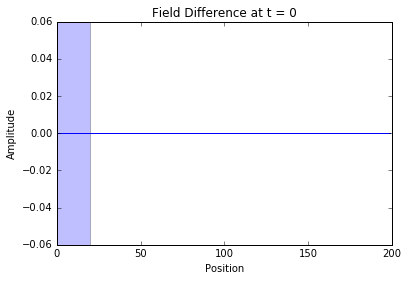

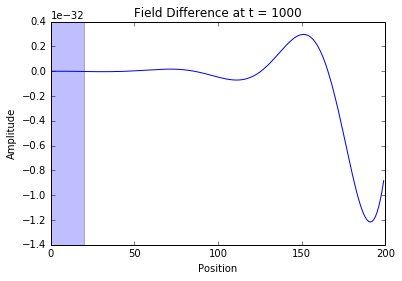

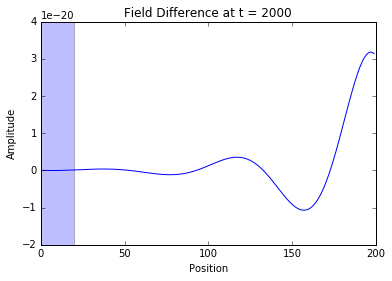

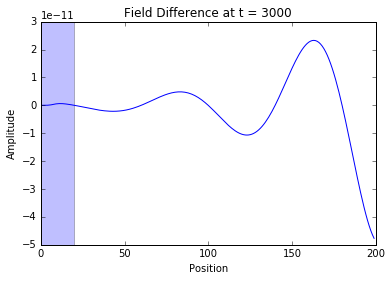

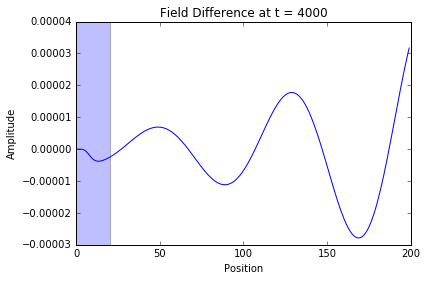

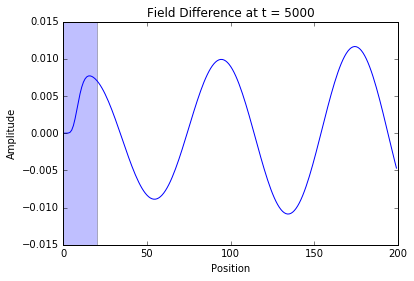

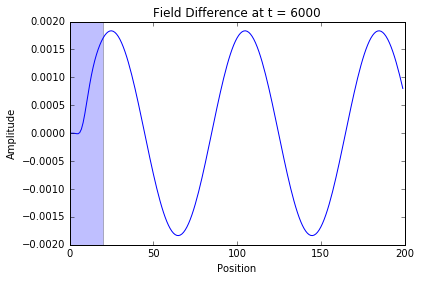

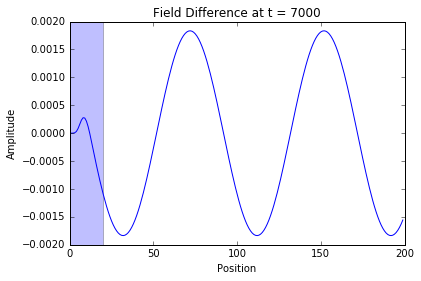

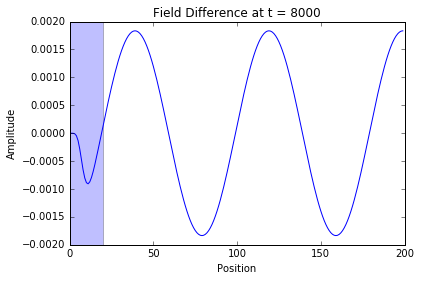

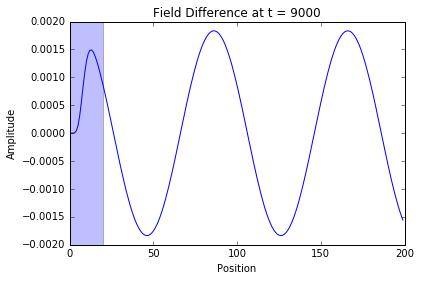

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math as m

fignum = 0

#some toggles for the plot
show_field_difference = 0
show_efield_and_refefield = 0
show_efield_only = 0
show_left_only = 1




nx = 400
imp0 = 377.0

wavelength = int(nx/5)
factor = 4
epshost = 1.2
epsmat = 4.0

nhost = np.sqrt(epshost)
nmat = np.sqrt(epsmat)

scale = nhost/nmat
#scale = nmat/nhost
thickness = wavelength/factor

#rescale thickness and nmat
nmat = ((thickness*nhost)/int(scale*thickness))
thickness = int(scale*thickness)

if factor == 4:
    nright = nmat**2/nhost
    epsright = nright**2

    epsmat = nmat**2
    eps = np.zeros(nx)
    eps[:] = epshost
    eps[int(nx/2):int(nx/2+thickness)] = epsmat
    eps[int(nx/2+thickness):] = epsright
elif factor == 2: 
    epsmat = nmat**2
    eps = np.zeros(nx)
    eps[:] = epshost
    eps[int(nx/2):int(nx/2)+thickness] = epsmat


c = 1/np.sqrt(eps[0])

refeps= np.zeros(nx)
refeps[:] = epshost

srcori = int(nx/10)              #source origin
srcwid = wavelength*3.0*np.sqrt(max(epshost,epsmat))
srcdel = 10*srcwid              #source delay
nt = int(10*nx+srcdel)

ez = np.zeros(nx)
hy = np.zeros(nx)
x = np.arange(0,nx-1,1)

refez = np.zeros(nx)
refhy = np.zeros(nx)





R0 = 1e-6          # reflection factor
gra = 4             # order of polynomial grading
dpml = 20           # number of PML cells

smax = -((gra+1)*m.log(R0))/(2*imp0*dpml)

es = np.zeros(nx)
hs = np.zeros(nx)

#polynomial gradng of the conductivity at the boundaries
for i in range(dpml):
    #for the left side of the PML
    es[i+1] = smax*((dpml-i-0.5)/dpml)**gra
    hs[i] = smax*((dpml-i)/dpml)**gra  
    
    #for the right side of the PML
    es[nx-i-1] = smax*((dpml-i-0.5)/dpml)**gra 
    hs[nx-i-1] = smax*((dpml-i)/dpml)**gra

ea = np.exp(-es*imp0)-1
eb = np.exp(-es*imp0)

ha = np.exp(-hs*imp0)-1
hb = np.exp(-hs*imp0)

psihy = np.zeros(nx)
psiez = np.zeros(nx)

refpsihy = np.zeros(nx)
refpsiez = np.zeros(nx)

amp = 1.0
for dt in range(0,nt):
    psihy[x] = hb[x]*psihy[x] + ha[x]*(ez[x+1] - ez[x])
    hy[x] = hy[x] + (ez[x+1] - ez[x])/imp0 + psihy[x]/imp0
    
    psiez[x+1] = eb[x+1]*psiez[x+1] + ea[x+1]*(hy[x+1]-hy[x])
    ez[x+1] = ez[x+1] + (hy[x+1]-hy[x])*imp0/eps[x+1] + psiez[x+1]*imp0/eps[x+1]

    if (dt > srcdel):
        amp = 1.0
    else:
        amp = m.exp(-((dt-srcdel)*(dt-srcdel))/(srcwid*srcwid))
    ez[srcori] += amp/np.sqrt(epshost)*np.sin(2*np.pi*dt*c/wavelength)



    refpsihy[x] = hb[x]*refpsihy[x] + ha[x]*(refez[x+1] - refez[x])
    refhy[x] = refhy[x] + (refez[x+1] - refez[x])/imp0 + refpsihy[x]/imp0
    
    refpsiez[x+1] = eb[x+1]*refpsiez[x+1] + ea[x+1]*(refhy[x+1]-refhy[x])
    refez[x+1] = refez[x+1] + (refhy[x+1]-refhy[x])*imp0/refeps[x+1] + refpsiez[x+1]*imp0/refeps[x+1]

    if (dt > srcdel):
        amp = 1.0
    else:
        amp = m.exp(-((dt-srcdel)*(dt-srcdel))/(srcwid*srcwid))
    refez[srcori] += amp/np.sqrt(epshost)*np.sin(2*np.pi*dt*c/wavelength)



#plot
    plt.hold(True)
    if (dt % 1000 == 0):
#    if (dt == srcdel+srcwid+(0.75*nx)):
        fignum = fignum + 1
        plt.figure(fignum)
        plt.xlabel("Position")
        plt.ylabel("Amplitude")

        if (show_field_difference):
            plt.axvspan(0, dpml, facecolor='b', alpha=0.25)
            plt.axvspan(nx-dpml, nx, facecolor='b', alpha=0.25)
            plt.xlim([0,nx])
            plt.axvspan(nx/2, thickness+nx/2, facecolor='g', alpha=0.25)
            plt.title("Field Difference at t = "+ str(dt))        
            plt.plot(ez-refez, label="E-field")        
        elif (show_efield_and_refefield):
            plt.axvspan(0, dpml, facecolor='b', alpha=0.25)
            plt.axvspan(nx-dpml, nx, facecolor='b', alpha=0.25)
            plt.xlim([0,nx])
            plt.axvspan(nx/2, thickness+nx/2, facecolor='g', alpha=0.25)
            plt.title("Field at t = "+ str(dt))        
            plt.plot(ez, label="E-field")
            plt.plot(refez, label="Ref. E-field")
            plt.legend()
        elif (show_efield_only):
            plt.axvspan(0, dpml, facecolor='b', alpha=0.25)
            plt.axvspan(nx-dpml, nx, facecolor='b', alpha=0.25)
            plt.xlim([0,nx])
            plt.axvspan(nx/2, thickness+nx/2, facecolor='g', alpha=0.25)
            plt.title("Field at t = "+ str(dt))        
            plt.plot(ez, label="E-field")                
        elif (show_left_only):
            plt.axvspan(0, dpml, facecolor='b', alpha=0.25)
            plt.xlim([0,nx/2])
            plt.title("Field Difference at t = "+ str(dt))        
            plt.plot(ez[:int(nx/2)]-refez[:int(nx/2)], label="E-field")
#        plt.plot(hy*imp0, label="H-field")
